In [110]:
import numpy as np
import itertools 
from math import comb
import matplotlib.pyplot as plt
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [155]:
n=4
def sort_funcs(func):
    return ''.join(str(i) for i in func)

permutations = list(itertools.permutations(list(range(n))))
permutations.sort()
yes_family = {permutations[i]: i for i in range(len(permutations))}
no_family = set()

for permutation in permutations:
    for i in range(len(permutation)):
        permutation = list(permutation)
        for v in range(n):
            if permutation[i] != v:
                # print(permutation)
                no_family.add(tuple(permutation[:i] + [v] + permutation[i+1:]))

no_family = list(no_family)
no_family.sort(key=sort_funcs)
# print(no_family)
no_family = {no_family[i]: i for i in range(len(no_family))}

In [156]:
# generates a list of all partial injective functions [n] to [n] with domain size k
# format: (inputs, outputs) such that f(intputs[i]) = f(outputs[i])
def all_injective(n, k):
    print(k)
    injectives_single = list(itertools.combinations(list(range(n)), k))
    return list(itertools.product(injectives_single, injectives_single))

# outputs ids for the functions from family agree with the partial function
def get_agreeable_indices(partial_injective, family):
    indices = []
    for function, i in family.items():
        # print(i, function)
        agree = True
        for index, output in zip(*partial_injective):
            if function[index] != output:
                agree = False
                break

        if agree:
            indices.append(i)
    return indices

# outputs the v_a and w_a vectors. In retrospect, these vectors aren't orthogonal
def get_basis_vector(partial_injective, family, n):
    agreeable = get_agreeable_indices(partial_injective, family)
    basis_vector = np.zeros(len(family))
    for i in agreeable:
        basis_vector[i] = 1
    return basis_vector / np.sqrt(len(agreeable))
    


# outputs projection onto the space spanned by no-instances that agree with k-sized partial injective functions
def no_space_projection(k, no_fam, n):
    projection = np.zeros((len(no_fam), len(no_fam)))
    all_partial_injectives = all_injective(n, k)
    no_vects = [get_basis_vector(injective, no_fam, n) for injective in all_partial_injectives]
    no_vects = np.asmatrix(no_vects).T
    # print(no_vects)
    ortho_basis = scipy.linalg.orth(no_vects)
    # print(ortho_basis)
    # print('mat', ortho_basis)
    basis_vectors = [np.asmatrix(ortho_basis)[:,i] for i in range(ortho_basis.shape[1])]
    # print(ortho_basis)
    for v in basis_vectors:
        projection += v @ v.T
    return projection
                          
def L_matrix(k, yes_fam, no_fam, n):
    projection = np.zeros((len(yes_fam), len(no_fam)))
    all_partial_injectives = all_injective(n, k)
    for injective_1 in all_partial_injectives:
        for injective_2 in all_partial_injectives:
            v = get_basis_vector(injective_1, yes_fam, n)
            u = get_basis_vector(injective_2, no_fam, n)
            # print(v)
            # input(np.asmatrix(v).T @ np.asmatrix(u))
            projection = projection + np.asmatrix(v).T @ np.asmatrix(u)
        
    return projection
    
def H_projection(k, no_fam, n):
    A_k = no_space_projection(k, no_fam, n)
    if k==0:
          return A_k
    I = np.identity(len(no_fam))
    A_km1 = no_space_projection(k-1, no_fam, n)
    return A_k @ (I - A_km1)

def get_adversary_matrix(n, yes_fam, no_fam):
    adv_mat = np.zeros((len(yes_fam), len(no_fam)))
    target = int(n**(2/3))+1
    print('target', target)
    for k in range(target):
        adv_mat = adv_mat + (target - k) * L_matrix(k, yes_fam, no_fam, n) @ H_projection(k, no_fam, n)
    return adv_mat
    
    


In [191]:
G = get_adversary_matrix(n, yes_family, no_family)
# target = int(n**(2/3))+1
# fig, axs = plt.subplots(target, 1)
# fig.suptitle('L_k Matrices')
# for k in range(target):
#     axs[k].imshow(L_matrix(k, yes_family, no_family, n))
#     pcm = axs[k].pcolormesh(no_space_projection(k, no_family, n))
#     fig.colorbar(pcm, ax=axs[k])
#     axs[k].set_title('k=' + str(k))

# plt.savefig('L_k.png')
# for k in range(target):
    
# H=no_space_projection(k, no_family, n)
# L=L_matrix(k, yes_family, no_family, n)
# print(np.max(L@H))
# plt.imshow((L@H).T)
# plt.colorbar()

target 3
0
0
1
1
0
2
2
1


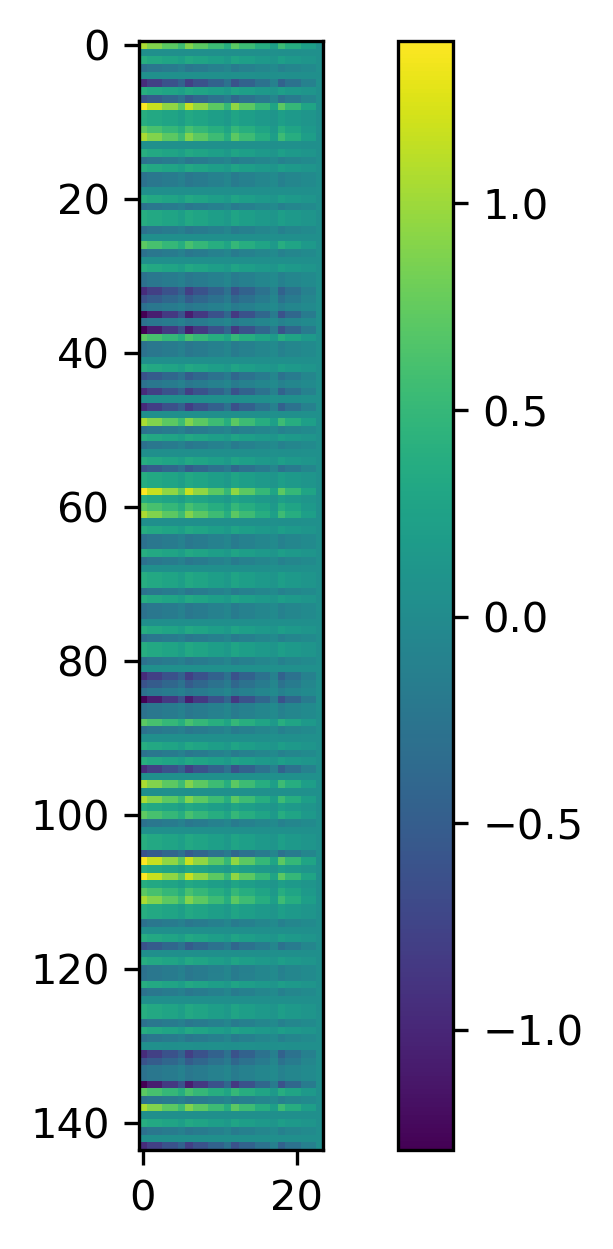

In [192]:
plt.imshow(G.T)
plt.colorbar()
plt.savefig('adv_mat.png')